In [1]:
import numpy as np
from   numpy import exp,cos,sin,pi,tan,sqrt,angle,absolute,eye,dot
import matplotlib.pyplot as plt
import seaborn # makes figures prettier (otherwise unused)
from DeDist import dedist
from __future__ import division
import dill
# removes need for plt.show() after every new plot
%matplotlib inline

In [3]:
# Set default figure size
plt.rcParams['figure.figsize'] = (10, 5)

In [523]:
# Restore session state i.e. all objects
# dill.load_session('session_state_gauss.pkl')

# Save current session state
# Unix compress file: $ gzip session_state.pkl
dill.dump_session('session_state_gauss.pkl')

Same model setup

In [4]:
# Tuning curve parameters
AMPLITUDE = 1.0
TUNING_WIDTH = 0.5

def tuning_curve(pref_stim, stimulus):
    return AMPLITUDE * exp( - (stimulus - pref_stim)**2 / (2 * TUNING_WIDTH**2) )

def tuning_curve_2d(pref_stim, stim_1, stim_2):
    return tuning_curve(pref_stim, stim_1) + tuning_curve(pref_stim, stim_2)

def tuning_curve_theta(pref_stim, opening_angle):
    return tuning_curve_2d(pref_stim, opening_angle/2, -opening_angle/2)

Construct correlation matrix $R$ using a Gaussian correlation profile

The matrix has the form: $r_{jk} = c(\phi_j - \phi_k) + \delta_{jk}(1 - c(0))$ 
where 
$$c(\phi_j - \phi_k) = c_0 \exp\bigg(-\frac{(\phi_j - \phi_k)^2}{2L^2}\bigg)$$

In [8]:
NOISE_SIGMA = 0.2

def construct_corr_matrix(max_corr, corr_length, n_neurons=100):
    pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
    pref_ang_dists = pref_stims - pref_stims[:,None]
    return max_corr * (exp(- (pref_ang_dists**2) / (2*corr_length**2) ) - eye(n_neurons)) + eye(n_neurons)

def construct_cov_matrix(max_corr=1.0, corr_length=0.5, n_neurons=100):
    corr_mtx = construct_corr_matrix(max_corr, corr_length, n_neurons)
    stds_mtx = NOISE_SIGMA * eye(n_neurons) 
    return dot(stds_mtx, dot(corr_mtx, stds_mtx))

Visualisation of correlation structure

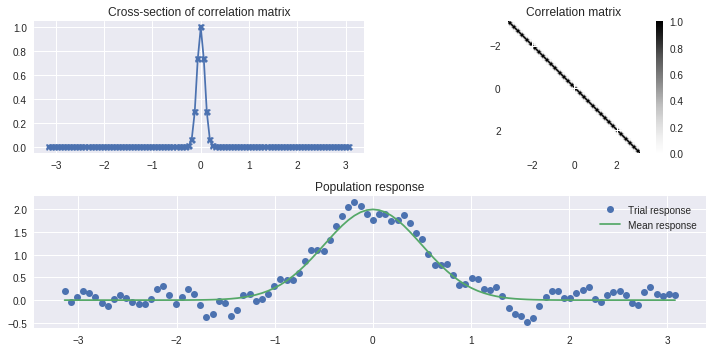

In [16]:
max_corr = 1.0
corr_length = 0.08

n_neurons = 100
pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]

# Cross-section of correlation matrix
plt.subplot(221) 
corr_mtx = construct_corr_matrix(max_corr, corr_length)
plt.plot(pref_stims, corr_mtx[50], '-X')
plt.title('Cross-section of correlation matrix')

# Correlation matrix
plt.subplot(222) 
data_coords = [pref_stims[0], pref_stims[-1], pref_stims[-1], pref_stims[0]]
plt.imshow(corr_mtx, cmap='Greys', extent=data_coords)
plt.colorbar()
plt.title('Correlation matrix')

# Population response
plt.subplot(212)
# sample population response
stim = 0.0
mean_pop_res = tuning_curve_theta(pref_stims, stim)
cov_mtx = construct_cov_matrix(max_corr, corr_length)
pop_res = np.random.multivariate_normal(mean_pop_res, cov_mtx)
plt.plot(pref_stims, pop_res, 'o', label='Trial response')
plt.plot(pref_stims, mean_pop_res, label='Mean response')
plt.legend()
plt.title('Population response')

plt.tight_layout()

In [17]:
# Candidate estimates to evaluate error function
N_CAND_ESTS = 100
CAND_ESTS = np.linspace(0, pi, N_CAND_ESTS+1)[:-1]

# Stimuli (opening angles) for which bias and variance are to be calculated
N_THETAS = 100
THETAS = np.linspace(0, pi/2, N_THETAS)

**ML code**

In [164]:
def get_ML_ests(cov_mtx, n_neurons=100, n_realisations=5000):    
    biases = np.zeros(N_THETAS)
    variances = np.zeros(N_THETAS)
    estimate_dists = np.zeros((N_THETAS, n_realisations))
    
    pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
    
    # Simulate neuron responses followed by decoding for each stimulus in THETAS
    for stim_idx in range(N_THETAS):
        stim = THETAS[stim_idx]
                
        # Generate noisy pop. responses by sampling multivariate distribution
        avg_pop_res = tuning_curve_theta(pref_stims, stim)
        pop_responses = np.random.multivariate_normal(avg_pop_res, cov_mtx, n_realisations)
                
        # For each noisy response, compute error wrt candidate stimuli
        avg_tuning_curves = tuning_curve_theta(pref_stims, CAND_ESTS[:,None])
        tmp = np.tensordot( (pop_responses-avg_tuning_curves[:,None]), np.linalg.pinv(cov_mtx), axes=1 )
        errors = np.einsum('ijk,ijk->ij', tmp, (pop_responses-avg_tuning_curves[:,None]))
        
        # Find minimum error stimuli for each realisation
        estimate_dists[stim_idx,:] = CAND_ESTS[errors.argmin(axis=0)]
        
        # Compute bias and variance
        mean_est = estimate_dists[stim_idx,:].mean()
        biases[stim_idx] = mean_est - stim
        variances[stim_idx] = ((estimate_dists[stim_idx,:] - mean_est)**2).mean()

    return [estimate_dists, biases, variances]

def get_ML_ests_stim_0(cov_mtx, n_neurons=100, n_realisations=5000):
    pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
    stim = 0.0
    estimate_dist = np.zeros(n_realisations)

    # Generate noisy pop. responses by sampling multivariate distribution
    avg_pop_res = tuning_curve_theta(pref_stims, stim)
    pop_responses = np.random.multivariate_normal(avg_pop_res, cov_mtx, n_realisations)

    # For each noisy response, compute error wrt candidate stimuli
    avg_tuning_curves = tuning_curve_theta(pref_stims, CAND_ESTS[:,None])
    tmp = np.tensordot( (pop_responses-avg_tuning_curves[:,None]), np.linalg.pinv(cov_mtx), axes=1 )
    errors = np.einsum('ijk,ijk->ij', tmp, (pop_responses-avg_tuning_curves[:,None]))

    # Find minimum error stimuli for each realisation
    estimate_dist[:] = CAND_ESTS[errors.argmin(axis=0)]

    # Compute bias and variance
    mean_est = estimate_dist.mean()
    bias = mean_est - stim
    variance = ((estimate_dist - mean_est)**2).mean()

    return (bias, variance)

Get the bias for uncorrelated model

In [93]:
cov_mtx = construct_cov_matrix(max_corr=0.0)
(bias_uncorr_theta_0, var_uncorr_theta_0) = get_ML_ests_stim_0(cov_mtx)

**Important Note**

We use the pseudo-inverse operation.

In [92]:
max_corr = 1.0

n_points = 100
corr_length_arr = np.logspace(start=-3, stop=6, num=n_points)
corr_length_arr = np.round(corr_length_arr, 4)

biases_theta_ML_inv = np.zeros(n_points)
variances_theta_ML_inv = np.zeros(n_points)

for i in range(n_points):
    cov_mtx = construct_cov_matrix(max_corr, corr_length_arr[i])
    (biases_theta_ML_inv[i], variances_theta_ML_inv[i]) = get_ML_ests_stim_0(cov_mtx)
    print i

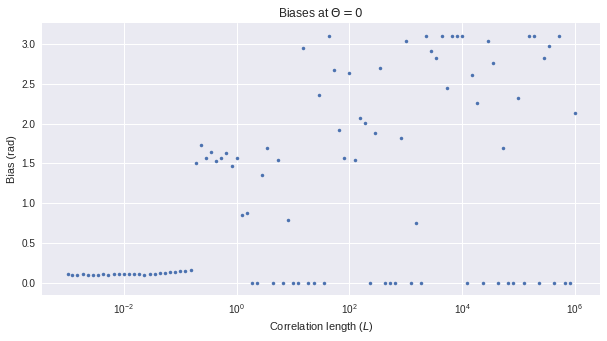

In [99]:
max_corr = 1.0
corr_length_arr = np.logspace(start=-3, stop=6, num=100)
corr_length_arr = np.round(corr_length_arr, 4)

plt.plot(corr_length_arr, biases_theta_ML_inv, '.')

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias (rad)')
plt.title('Biases at $\Theta = 0$')

The above shows the result when we use the standard inverse operation.

**Bias vs correlation length at $\Theta=0$**

In [73]:
max_corr = 1.0

n_points = 500
corr_length_arr = np.logspace(start=-3, stop=6, num=n_points)
corr_length_arr = np.round(corr_length_arr, 4)

biases_theta_ML = np.zeros(n_points)
variances_theta_ML = np.zeros(n_points)

for i in range(n_points):
    cov_mtx = construct_cov_matrix(max_corr, corr_length_arr[i])
    (biases_theta_ML[i], variances_theta_ML[i]) = get_ML_ests_stim_0(cov_mtx)
    print i

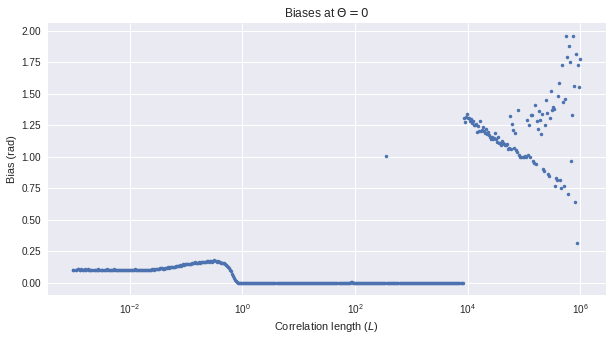

In [101]:
max_corr = 1.0
corr_length_arr = np.logspace(start=-3, stop=6, num=500)
corr_length_arr = np.round(corr_length_arr, 4)

plt.plot(corr_length_arr, biases_theta_ML, '.')

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias (rad)')
plt.title('Biases at $\Theta = 0$')

For $L > 10^{4}$, the bias fluctates randomly away from 0.

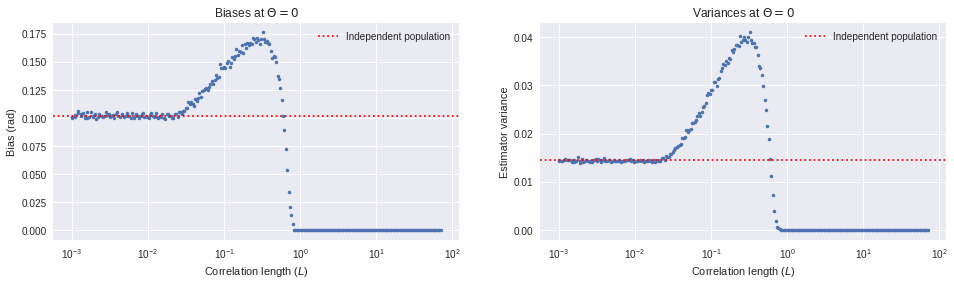

In [488]:
max_corr = 1.0
corr_length_arr = np.logspace(start=-3, stop=6, num=500)
corr_length_arr = np.round(corr_length_arr, 4)

end_idx = 270

plt.rcParams['figure.figsize'] = (16, 4)

plt.subplot(121)
plt.plot(corr_length_arr[:end_idx], biases_theta_ML[:end_idx], '.')
plt.axhline(y=bias_uncorr_theta_0, color='r', linestyle=':', label='Independent population')

plt.legend()
plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias (rad)')
plt.title('Biases at $\Theta = 0$')

plt.subplot(122)
plt.plot(corr_length_arr[:end_idx], variances_theta_ML[:end_idx], '.')
plt.axhline(y=var_uncorr_theta_0, color='r', linestyle=':', label='Independent population')

plt.legend()
plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Estimator variance')
plt.title('Variances at $\Theta = 0$')

plt.rcParams['figure.figsize'] = (10, 5)

Determine correlation length of maximum bias at $\Theta=0$

In [176]:
corr_length_arr = np.logspace(start=-3, stop=6, num=500)
c = np.round(corr_length_arr, 4)

end_idx = 270

idx = np.argmax(biases_theta_ML[:end_idx])
print 'L = {0}'.format(corr_length_arr[idx])
print 'Bias = {0:.4f}'.format(biases_theta_ML[idx])

L = 0.3214
Bias = 0.1762


Bias (across THETAS) for selected correlation lengths

In [484]:
def get_corr_param_dict_lbl(max_corr=1.0, corr_length=0.5):
    return 'max_corr='+str(max_corr)+';corr_length='+str(corr_length)

In [483]:
max_corr = 1.0
corr_length_arr = np.asarray([0.054, 0.124, 0.321, 0.647, 0.682, 0.727])

ML_ests = dict()
for corr_length in corr_length_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    ML_ests[lbl] = get_ML_ests(cov_mtx)

Bias (across THETAS) for $\Theta = 0$

In [485]:
max_corr = 0.0

cov_mtx = construct_cov_matrix(max_corr)
lbl = get_corr_param_dict_lbl(max_corr)
ML_ests[lbl] = get_ML_ests(cov_mtx)

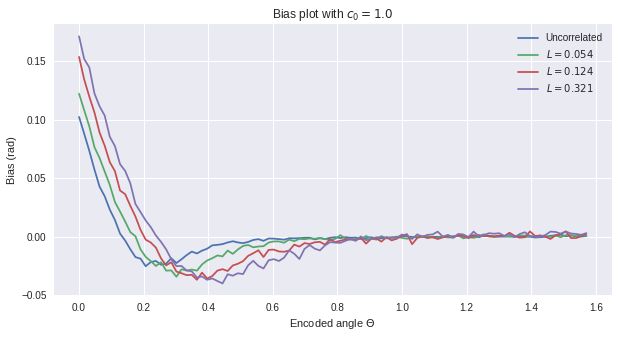

In [498]:
corr_length_arr = np.asarray([0.054, 0.124, 0.321, 0.647, 0.682, 0.727])

lbl = get_corr_param_dict_lbl(max_corr=0.0) # Uncorrelated case
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, label='Uncorrelated')

corr_length = corr_length_arr[0]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

corr_length = corr_length_arr[1]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

corr_length = corr_length_arr[2]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

plt.legend()
plt.title('Bias plot with $c_0 = 1.0$')
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')

Correlation lengths resulting in increased bias where $L = 0.321$ is the peak bias at $\Theta = 0$from plot above.

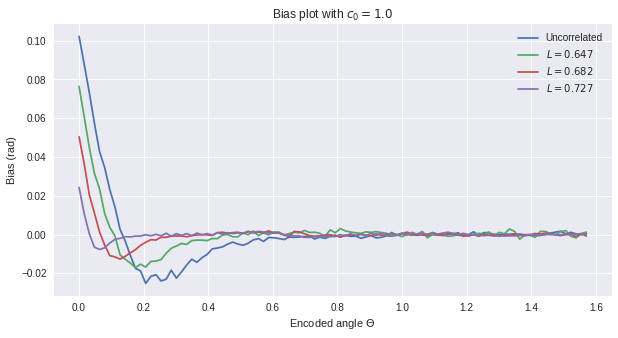

In [499]:
corr_length_arr = np.asarray([0.054, 0.124, 0.321, 0.647, 0.682, 0.727])

lbl = get_corr_param_dict_lbl(max_corr=0.0) # Uncorrelated case
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, label='Uncorrelated')

corr_length = corr_length_arr[3]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

corr_length = corr_length_arr[4]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

corr_length = corr_length_arr[5]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

plt.legend()
plt.title('Bias plot with $c_0 = 1.0$')
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')

Correlation lengths resulting in reduced bias.

Distribution of estimates for true stimulus value 0


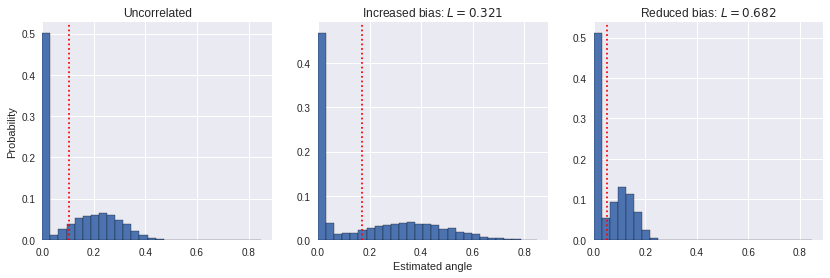

In [522]:
print('Distribution of estimates for true stimulus value 0')

plt.rcParams['figure.figsize'] = (14, 4)

end_idx = 28

plt.subplot(131)
lbl = get_corr_param_dict_lbl(max_corr=0.0)
est_dist = ML_ests[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:end_idx], edgecolor='black')
plt.axvline(x=ML_ests[lbl][1][0], color='r', ls=':')
plt.xlim(0)
plt.ylabel('Probability')
plt.title('Uncorrelated')


plt.subplot(132)
corr_length = 0.321
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
est_dist = ML_ests[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:end_idx], edgecolor='black')
plt.axvline(x=ML_ests[lbl][1][0], color='r', ls=':')
plt.xlim(0)
plt.xlabel('Estimated angle')
plt.title('Increased bias: $L = {0}$'.format(corr_length))


plt.subplot(133)
corr_length = 0.682
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
est_dist = ML_ests[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:end_idx], edgecolor='black')
plt.axvline(x=ML_ests[lbl][1][0], color='r', ls=':')
plt.xlim(0)
plt.title('Reduced bias: $L = {0}$'.format(corr_length))


plt.rcParams['figure.figsize'] = (10, 5)
